In [45]:
import numpy as np
from Utility import gradient, gradient_first, gradient_second, gradient_first_f2c, gradient_first_c2f, interpolate_f2c, interpolate_c2f
import matplotlib.pyplot as plt


N = 100
x = np.linspace(0,2*np.pi,N)
y   = np.sin(2*x)+np.cos(5*x)
dy  = 2*np.cos(2*x)-5*np.sin(5*x)
ddy = -4*np.sin(2*x)-25*np.cos(5*x)


dx = x[1] - x[0]
x_c   = np.linspace(0+dx/2, 2*np.pi-dx/2, N-1)
y_c   = np.sin(2*x_c)+np.cos(5*x_c)
dy_c  = 2*np.cos(2*x_c)-5*np.sin(5*x_c)
ddy_c = -4*np.sin(2*x_c)-25*np.cos(5*x_c)


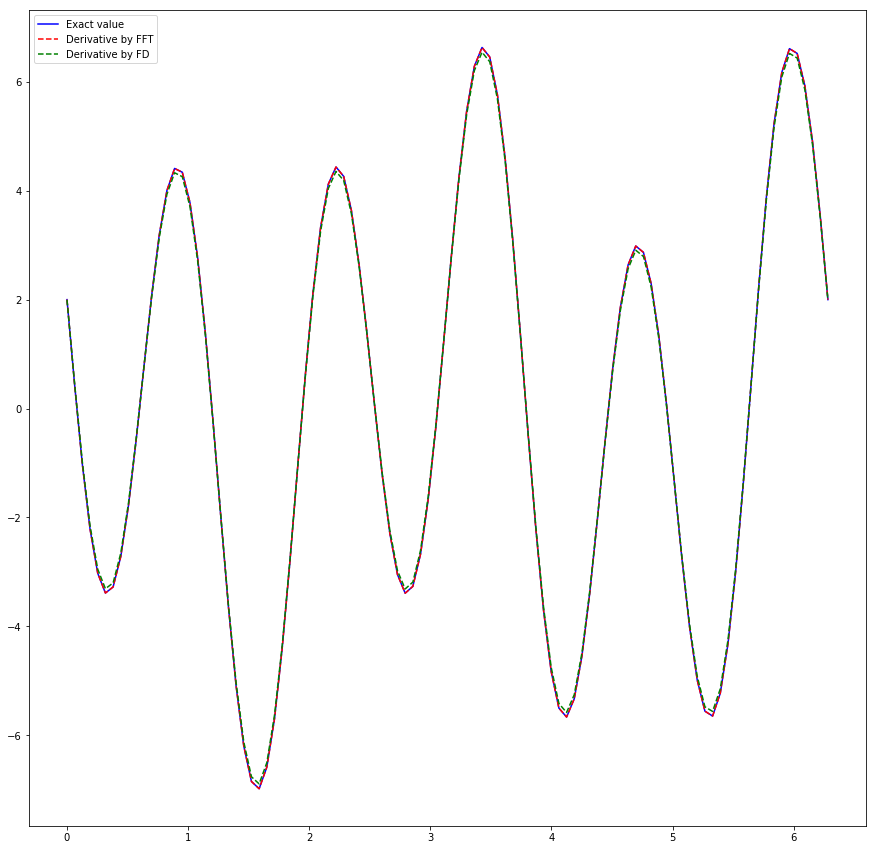

In [38]:
# first order test : gradient_first
order = 1
dydx = gradient(y, dx, order)
dydx_fd = gradient_first(y, dx)
plt.figure(figsize=(15,15))
plt.plot(x,dy,'b',label='Exact value')
plt.plot(x,dydx,'--r',label='Derivative by FFT')
plt.plot(x,dydx_fd,'--g',label='Derivative by FD')
plt.legend()
plt.show()

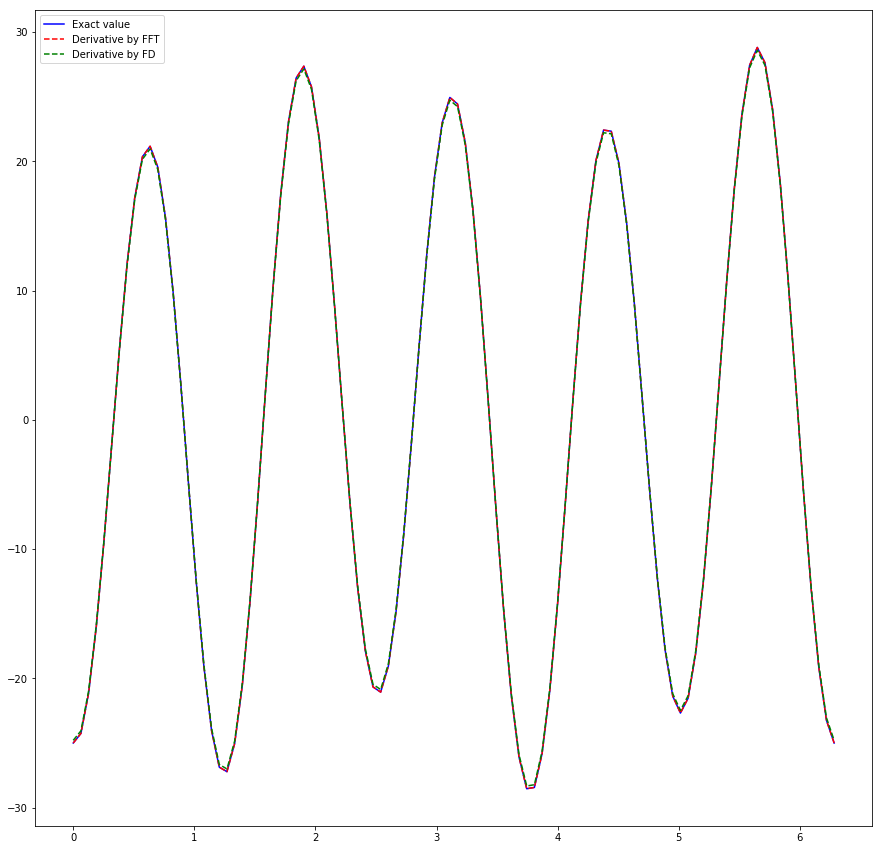

In [39]:
# second order test
order = 2
ddydx = gradient(y, dx, order)
ddydx_fd = gradient_second(y, dx)
plt.figure(figsize=(15,15))
plt.plot(x,ddy,'b',label='Exact value')
plt.plot(x,ddydx,'--r',label='Derivative by FFT')
plt.plot(x,ddydx_fd,'--g',label='Derivative by FD')
plt.legend()
plt.show()

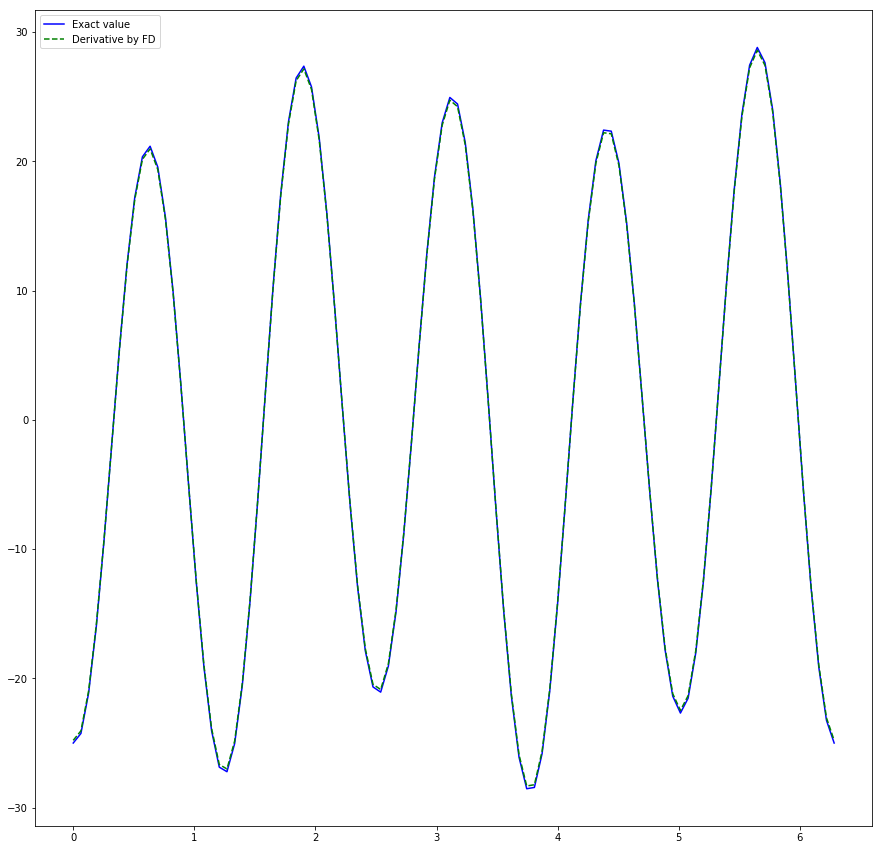

In [40]:
# second order test : gradient_first_f2c, gradient_first_c2f
order = 2
dydx_c = gradient_first_f2c(y, dx)
ddydx_f = gradient_first_c2f(dydx_c, dx)
plt.figure(figsize=(15,15))
plt.plot(x,ddy,'b',label='Exact value')
plt.plot(x,ddydx_f,'--g',label='Derivative by FD')
plt.legend()
plt.show()

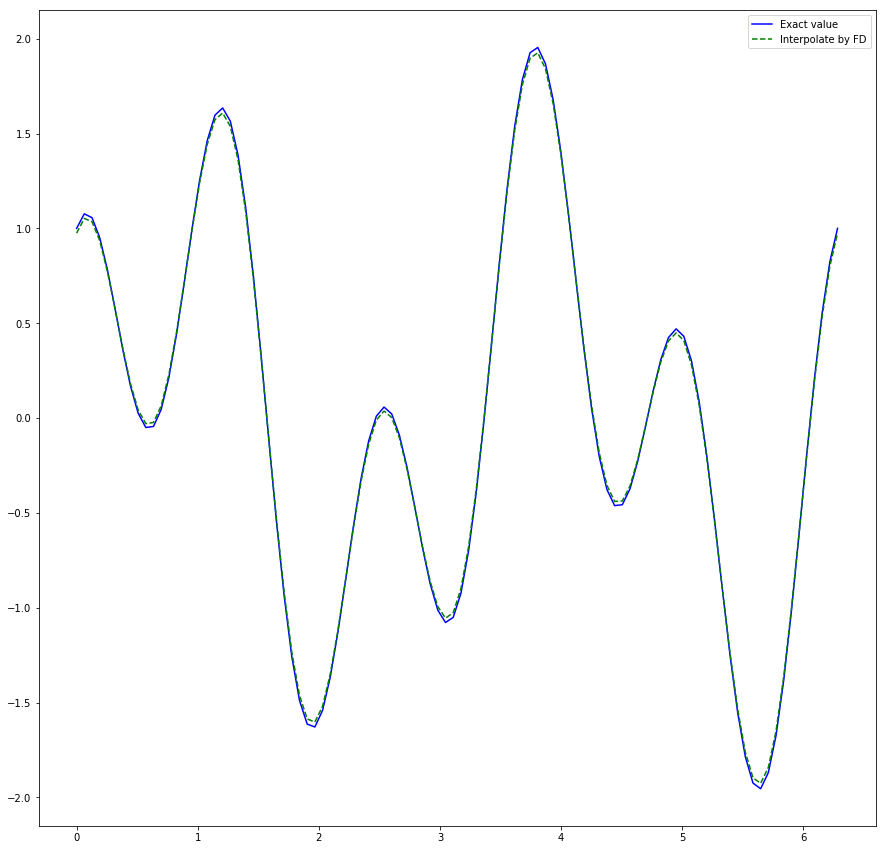

In [41]:
# interpolation test : interpolate_f2c, interpolate_c2f
order = 2
y_c = interpolate_f2c(y)
y_f = interpolate_c2f(y_c)
plt.figure(figsize=(15,15))
plt.plot(x,y,'b',label='Exact value')
plt.plot(x,y_f,'--g',label='Interpolate by FD')
plt.legend()
plt.show()

In [2]:
# Psi solver verification

import numpy as np
from Utility import psi_fd_sol, psi_fft_sol
import matplotlib.pyplot as plt

#q_1 = dd psi_1 + F1(psi_2 - psi_1)
#q_2 = dd psi_2 + F2(psi_1 - psi_2)


N = 100
x = np.linspace(0,2*np.pi,N)
F1, F2 = 1.0, 2.0
psi_1 = np.sin(2*x)
psi_2 = np.cos(5*x)
q_1   = -4*np.sin(2*x)  + F1*(psi_2 - psi_1)
q_2   = -25*np.cos(5*x) + F2*(psi_1 - psi_2)
dx = x[1] - x[0]
q = np.vstack((q_1, q_2))

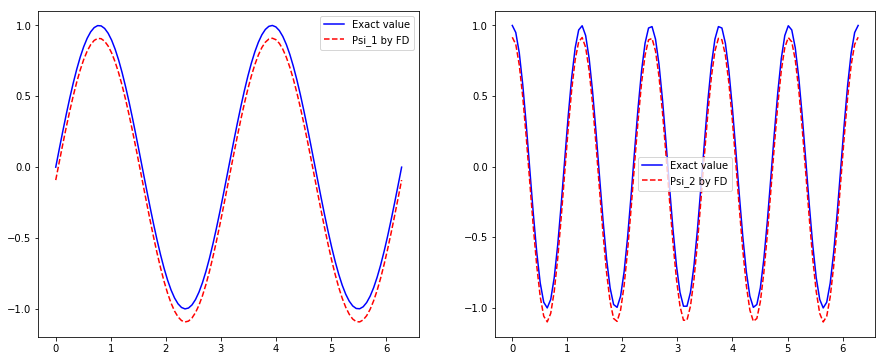

In [3]:
psi_fd = psi_fd_sol(q, F1, F2, dx)
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(x, psi_1,'b',label='Exact value')
ax[0].plot(x, psi_fd[0, :],'--r',label='Psi_1 by FD')
ax[0].legend()
ax[1].plot(x, psi_2,'b',label='Exact value')
ax[1].plot(x, psi_fd[1, :],'--r',label='Psi_2 by FD')
ax[1].legend()


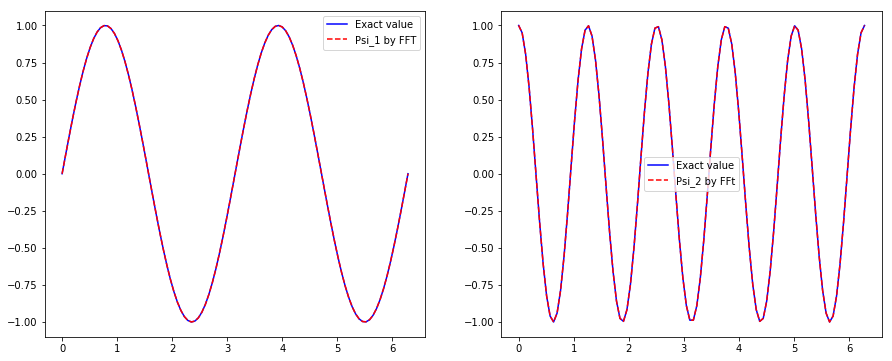

In [4]:
psi_fft = psi_fft_sol(q, F1, F2, dx)
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(x, psi_1,'b',label='Exact value')
ax[0].plot(x, psi_fft[0, :],'--r',label='Psi_1 by FFT')
ax[0].legend()
ax[1].plot(x, psi_2,'b',label='Exact value')
ax[1].plot(x, psi_fft[1, :],'--r',label='Psi_2 by FFt')
ax[1].legend()

In [10]:
import numpy as np
from scipy.fftpack import fft, ifft
from scipy.sparse.linalg import spsolve
from scipy import sparse

_, nx = q.shape 
N = nx - 1 # open periodic domain
k2= np.zeros(N)

if ((N%2)==0):
    #-even number                                                                                   
    for i in range(1,N//2):
        k2[i]   =  i
        k2[N-i] = -i
else:
    #-odd number                                                                                    
    for i in range(1,(N-1)//2):
        k2[i]   =  i
        k2[N-i] = -i

ddx = -k2**2

q_h   = np.zeros((2, N), dtype=np.complex)
psi_h = np.zeros((2, N), dtype=np.complex)
psi = np.copy(q)

q_h[0, :], q_h[1, :] = fft(q[0,0:N]), fft(q[1,0:N])

for i in range(N):
    det = ddx[i]**2 - (F2 + F1)*ddx[i]
    if abs(det < 1e-10):
        psi_h[0,i], psi_h[1,i] = 0.0, 0.0
    else:
        psi_h[0,i] = ((ddx[i]-F2)*q_h[0,i] - F1*q_h[1,i])/det 
        psi_h[1,i] = (-F2*q_h[0,i] + (ddx[i]-F1)*q_h[1,i])/det


psi[0, 0:N] = ifft(psi_h[0,:]).real
psi[1, 0:N] = ifft(psi_h[1,:]).real


psi[0, N] = psi[0, 0]
psi[1, N] = psi[1, 0]


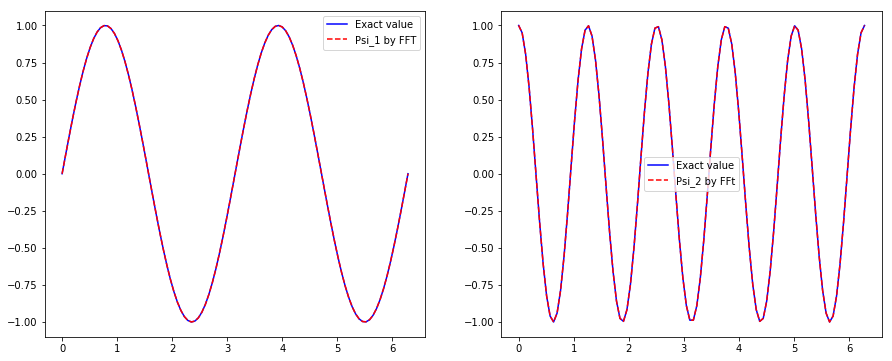

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(x, psi_1,'b',label='Exact value')
ax[0].plot(x, psi[0, :],'--r',label='Psi_1 by FFT')
ax[0].legend()
ax[1].plot(x, psi_2,'b',label='Exact value')
ax[1].plot(x, psi[1, :],'--r',label='Psi_2 by FFt')
ax[1].legend()